# DO UPVOTE GUYS!!!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ts-forecasting/train.parquet
/kaggle/input/ts-forecasting/test.parquet


# Key ideas:
- Separate models per forecast horizon
- Cross-sectional normalization at each timestep
- Interaction features capturing relative movements
- Strict time-based validation

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
import lightgbm as lgb
import gc

In [4]:
train_path = '/kaggle/input/ts-forecasting/train.parquet'
test_path = '/kaggle/input/ts-forecasting/test.parquet'
val_threshold = 3500

#print("Computing Stats...")
temp = pd.read_parquet(
    train_path,
    columns=['sub_category', 'sub_code', 'y_target', 'ts_index']
)

train_only = temp[temp.ts_index <= val_threshold]

train_stats = {
    'sub_category': train_only.groupby('sub_category')['y_target'].mean().to_dict(),
    'sub_code': train_only.groupby('sub_code')['y_target'].mean().to_dict(),
    'global_mean': train_only['y_target'].mean()
}

del temp, train_only
gc.collect()


13

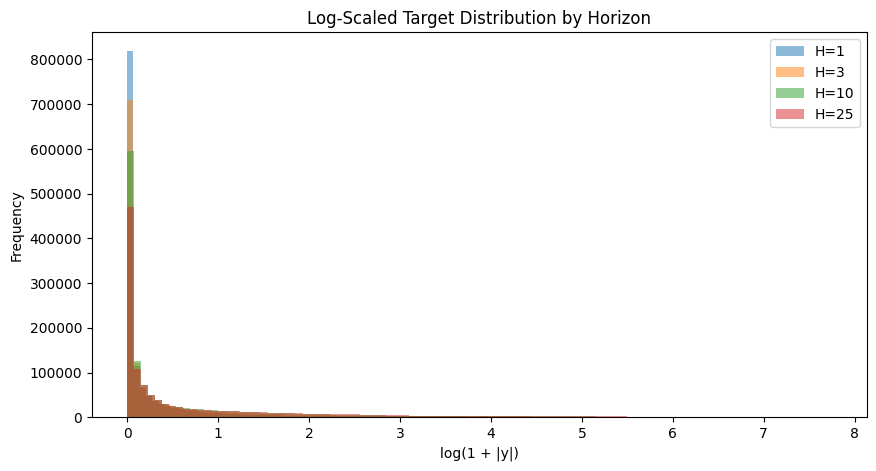

In [5]:
import matplotlib.pyplot as plt

sample = pd.read_parquet(train_path, columns=['y_target', 'horizon'])

plt.figure(figsize=(10, 5))
for h in sorted(sample['horizon'].unique()):
    vals = sample[sample.horizon == h]['y_target']
    plt.hist(np.log1p(np.abs(vals)), bins=100, alpha=0.5, label=f'H={h}')

plt.legend()
plt.title("Log-Scaled Target Distribution by Horizon")
plt.xlabel("log(1 + |y|)")
plt.ylabel("Frequency")
plt.show()


We construct **context-aware features** using only valid historical data.

### 1️⃣ Encoded Categorical Signals
Mean target encoding for:
- `sub_category`
- `sub_code`

(Computed only on `ts_index ≤ validation_threshold`)

### 2️⃣ Interaction Features
- Differences: `feature_al - feature_am`
- Ratios: `feature_al / feature_am`
- Cross-feature contrasts

### 3️⃣ Cross-Sectional Normalization
Z-score normalization **within each ts_index**

### 4️⃣ Temporal Cyclic Signal
Sinusoidal encoding of time:


In [6]:
def build_context_features(data, enc_stats=None):
    x = data.copy()

    # Encoded categorical signals
    if enc_stats is not None:
        for c in ['sub_category', 'sub_code']:
            x[c + '_enc'] = x[c].map(enc_stats[c]).fillna(enc_stats['global_mean'])

    # Interaction features
    x['d_al_am'] = x['feature_al'] - x['feature_am']
    x['r_al_am'] = x['feature_al'] / (x['feature_am'] + 1e-7)
    x['d_cg_by'] = x['feature_cg'] - x['feature_by']

    # Cross-sectional normalization
    norm_cols = ['feature_al', 'feature_am', 'feature_cg', 'feature_by', 'd_al_am']

    for col in norm_cols:
        g = x.groupby('ts_index')[col]
        x[col + '_cs'] = (x[col] - g.transform('mean')) / (g.transform('std') + 1e-7)

    # Temporal signal
    x['t_cycle'] = np.sin(2 * np.pi * x['ts_index'] / 100)

    return x


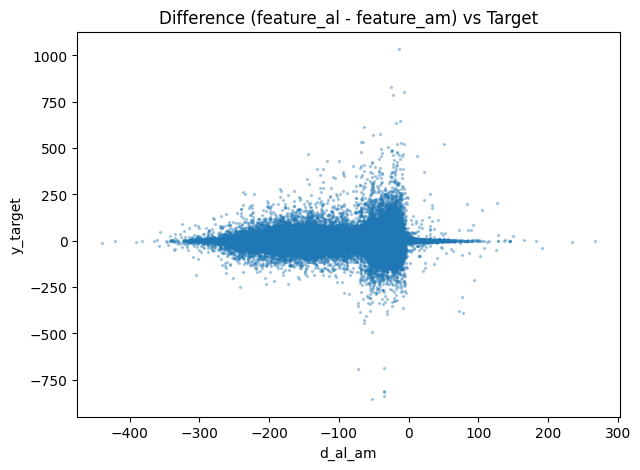

In [7]:
tmp = pd.read_parquet(train_path).query("horizon == 1 and ts_index <= 3500")
tmp = build_context_features(tmp, train_stats)

plt.figure(figsize=(7, 5))
plt.scatter(tmp['d_al_am'], tmp['y_target'], s=2, alpha=0.3)
plt.title("Difference (feature_al - feature_am) vs Target")
plt.xlabel("d_al_am")
plt.ylabel("y_target")
plt.show()


In [8]:
forecast_windows = [1, 3, 10, 25]
test_outputs = []
cv_cache = {'y': [], 'pred': [], 'wt': []}

lgb_cfg = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.015,
    'n_estimators': 4000,
    'num_leaves': 80,
    'min_child_samples': 200,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 10.0,
    'verbosity': -1
}

The competition uses a **weighted skill-score inspired metric**:


### Properties
- Higher is better
- Penalizes large weighted errors
- Robust to scale differences across horizons

In [9]:
def weighted_rmse_score(y_target, y_pred, w):
    y_target, y_pred, w = np.array(y_target), np.array(y_pred), np.array(w)
    denom = np.sum(w * (y_target ** 2))
    if denom <= 0:
        return 0.0
    numerator = np.sum(w * ((y_target - y_pred) ** 2))
    ratio = numerator / denom
    return float(np.sqrt(1.0 - np.clip(ratio, 0.0, 1.0)))


## ⏳ Horizon-Wise Training

For each horizon ∈ {1, 3, 10, 25}:
1. Build features
2. Time-based train/validation split
3. Train 2 seeds
4. Average predictions

In [10]:
for hz in forecast_windows:
    print(f"\n>>> Training horizon = {hz}")

    tr_df = build_context_features(
        pd.read_parquet(train_path).query(f"horizon == {hz}"),
        train_stats
    )
    te_df = build_context_features(
        pd.read_parquet(test_path).query(f"horizon == {hz}"),
        train_stats
    )

    feature_cols = [
        c for c in tr_df.columns
        if c not in {
            'id', 'code', 'sub_code', 'sub_category',
            'horizon', 'ts_index', 'weight', 'y_target'
        }
    ]

    fit_mask = tr_df.ts_index <= val_threshold
    val_mask = tr_df.ts_index > val_threshold

    X_fit = tr_df.loc[fit_mask, feature_cols]
    y_fit = tr_df.loc[fit_mask, 'y_target']
    w_fit = tr_df.loc[fit_mask, 'weight']

    X_hold = tr_df.loc[val_mask, feature_cols]
    y_hold = tr_df.loc[val_mask, 'y_target']
    w_hold = tr_df.loc[val_mask, 'weight']

    val_pred = np.zeros(len(y_hold))
    tst_pred = np.zeros(len(te_df))

    for seed in (42, 2024):
        mdl = lgb.LGBMRegressor(**lgb_cfg, random_state=seed)

        mdl.fit(
            X_fit,
            y_fit,
            sample_weight=w_fit,
            eval_set=[(X_hold, y_hold)],
            eval_sample_weight=[w_hold],
            callbacks=[lgb.early_stopping(200, verbose=False)]
        )

        val_pred += mdl.predict(X_hold) / 2
        tst_pred += mdl.predict(te_df[feature_cols]) / 2

    cv_cache['y'].extend(y_hold.tolist())
    cv_cache['pred'].extend(val_pred.tolist())
    cv_cache['wt'].extend(w_hold.tolist())

    print(
        f"Horizon {hz} Score: "
        f"{weighted_rmse_score(y_hold, val_pred, w_hold):.5f}"
    )

    test_outputs.append(
        pd.DataFrame({'id': te_df['id'], 'prediction': tst_pred})
    )

    del tr_df, te_df
    gc.collect()


>>> Training horizon = 1
Horizon 1 Score: 0.08133

>>> Training horizon = 3
Horizon 3 Score: 0.12690

>>> Training horizon = 10
Horizon 10 Score: 0.22697

>>> Training horizon = 25
Horizon 25 Score: 0.27680


In [11]:
final_metric = weighted_rmse_score(cv_cache['y'], cv_cache['pred'], cv_cache['wt'])

print(
    f"\n{'='*40}\n"
    f"FINAL AGGREGATE SCORE: {final_metric:.6f}\n"
    f"{'='*40}"
)

pd.concat(test_outputs).to_csv('submission.csv', index=False)



FINAL AGGREGATE SCORE: 0.238345
